<a href="https://colab.research.google.com/github/Kirti-Pant/X-RVV-/blob/main/X_RVV_Model_Code_and_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Dependencies

In [ ]:
!pip install tensorflow;
!pip install keras;
!pip install opencv-python;
!pip install matplotlib;
!pip install pandas;
!pip install numpy;
!pip install scikit-learn;
!pip install seaborn;
!pip install matplotlib;
!pip install transformers;
!pip install tf-keras-vis --quiet

In [ ]:
!pip install timm

In [ ]:
!pip install segmentation-models tensorflow_addons
!pip install git+https://github.com/qubvel/segmentation_models

# Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Dataset Preparation and Sample Image Display

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil

data_folder = '/content/drive/MyDrive/data'
dataset_path = '/content/dataset'


if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

subfolders = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]
for folder in subfolders:
    source_folder = os.path.join(data_folder, folder)
    destination_folder = os.path.join(dataset_path, folder)

    if not os.path.exists(destination_folder):
        shutil.copytree(source_folder, destination_folder)
    else:
        print(f"Folder {folder} already exists in {dataset_path}. Skipping.")
    print(f"Copied {folder} to {destination_folder}")


all_image_paths = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_image_paths.append(os.path.join(root, file))

if all_image_paths:
    random_image_path = random.choice(all_image_paths)
    img = mpimg.imread(random_image_path)
    plt.imshow(img)
    plt.title(f"Random Image from {random_image_path}")
    plt.axis('off')
    plt.show()
else:
    print("No images found in the dataset.")

#  Dataset Image Count by Class

In [ ]:
category_counts = {}
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        num_images = len([f for f in os.listdir(category_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        category_counts[category] = num_images

# Print the results:
for category, count in category_counts.items():
    print(f"Category '{category}': {count} images")

# Count of Total Images

In [ ]:
import os

dataset_path = '/content/dataset'
total_images = 0
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
               total_images += 1

print(f"Total number of images in the dataset: {total_images}")

#Data Loading, Preprocessing, and Splitting Setup

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import cv2


data_folder = '/content/drive/MyDrive/data'
dataset_path = '/content/dataset'

IMG_SIZE = 224

image_paths = []
labels = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(os.path.dirname(os.path.join(root, file))))



train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)


val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42
)


def load_and_resize(path):
    img = mpimg.imread(path)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

train_images = np.array([load_and_resize(path) for path in train_paths])
val_images = np.array([load_and_resize(path) for path in val_paths])
test_images = np.array([load_and_resize(path) for path in test_paths])


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)


from tensorflow.keras.utils import to_categorical
train_labels_categorical = to_categorical(train_labels_encoded)
val_labels_categorical = to_categorical(val_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_datagen.flow(
    train_images,
    train_labels_categorical,
    batch_size=32,
    shuffle=False
)


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_data = val_datagen.flow(
    val_images,
    val_labels_categorical,
    batch_size=32,

)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow(
    test_images,
    test_labels_categorical,
    batch_size=32,
    shuffle=False

)

In [ ]:
from collections import Counter
train_class_counts = Counter(train_labels)
print("Number of images per class in Training Set:")
for label, count in train_class_counts.items():
    print(f"Category '{label}': {count} images")

val_class_counts = Counter(val_labels)
print("\nNumber of images per class in Validation Set:")
for label, count in val_class_counts.items():
    print(f"Category '{label}': {count} images")

test_class_counts = Counter(test_labels)
print("\nNumber of images per class in Testing Set:")
for label, count in test_class_counts.items():
    print(f"Category '{label}': {count} images")

#Data Augmentation

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


augmented_train_dir = '/content/augmented_data'
os.makedirs(augmented_train_dir, exist_ok=True)


augmentations_per_image = 3

print(f"Augmenting {len(train_paths)} training images. Generating {augmentations_per_image} augmented images per original image.")

for i, img_path in enumerate(train_paths):
    try:
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)


        category = os.path.basename(os.path.dirname(img_path))


        category_folder = os.path.join(augmented_train_dir, category)
        os.makedirs(category_folder, exist_ok=True)


        prefix = f"{os.path.splitext(os.path.basename(img_path))[0]}_aug"


        gen_count = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=category_folder, save_prefix=prefix, save_format='jpeg'):
            gen_count += 1
            if gen_count >= augmentations_per_image:
                break

    except Exception as e:
        print(f"Error augmenting image {img_path}: {e}")

print("Augmentation process complete.")



Augmenting 2296 training images. Generating 3 augmented images per original image.
Augmentation process complete.


# **X-RVV with Data Augmentation**

In [ ]:
import tensorflow as tf
from keras.applications import ResNet50, VGG19
from keras.layers import Input, Dense, Dropout, concatenate, GlobalAveragePooling2D, Resizing, Rescaling
from keras.models import Model
from keras.optimizers import Adam
from transformers import TFViTModel
import segmentation_models as sm


vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

IMG_SIZE = 224
NUM_CLASSES = 4


input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')


resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
resnet_out = GlobalAveragePooling2D()(resnet.output)


vgg = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
vgg_out = GlobalAveragePooling2D()(vgg.output)


vit_input = Resizing(224, 224)(input_tensor)
vit_input = Rescaling(1./255)(vit_input)

class TransposeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.transpose(inputs, perm=[0, 3, 1, 2])

vit_input_transposed = TransposeLayer()(vit_input)

class ViTBranch(tf.keras.layers.Layer):
    def call(self, inputs, training=False):
        outputs = vit_model({'pixel_values': inputs})
        return outputs.last_hidden_state[:, 0, :]

vit_out = ViTBranch()(vit_input_transposed)


merged = concatenate([resnet_out, vgg_out, vit_out])
x = Dense(1024, activation='relu')(merged)
x = Dropout(0.6)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
classification_output = Dense(NUM_CLASSES, activation='softmax', name='classification_output')(x)

segmentation_output = sm.Unet(
    backbone_name='resnet34',
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)(input_tensor)
segmentation_output._name = 'segmentation_output'

model = Model(inputs=input_tensor, outputs=[classification_output, segmentation_output], name="functional_37")


classification_model = Model(inputs=model.input, outputs=model.get_layer('classification_output').output, name="functional_37")


classification_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

classification_model.summary()


Segmentation Models: using `keras` framework.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 47,547,844 (181.38 MB)

 Trainable params: 47,494,724 (181.18 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = classification_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        keras.callbacks.ModelCheckpoint('best_hybrid_model2.keras', save_best_only=True)
    ]
)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.9973 - loss: 0.0079 - val_accuracy: 0.9797 - val_loss: 0.0723
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.9982 - loss: 0.0084 - val_accuracy: 0.9833 - val_loss: 0.0746
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.9971 - loss: 0.0072 - val_accuracy: 0.9760 - val_loss: 0.0924
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.9976 - loss: 0.0085 - val_accuracy: 0.9797 - val_loss: 0.0730
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.9957 - loss: 0.0142 - val_accuracy: 0.9775 - val_loss: 0.0823
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.9944 - loss: 0.0225 - val_accuracy: 0.9884 - val_loss: 0.0397
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.9989 - loss: 0.0040 - val_accuracy: 0.9855 - val_loss: 0.0444
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.9991 - loss: 0

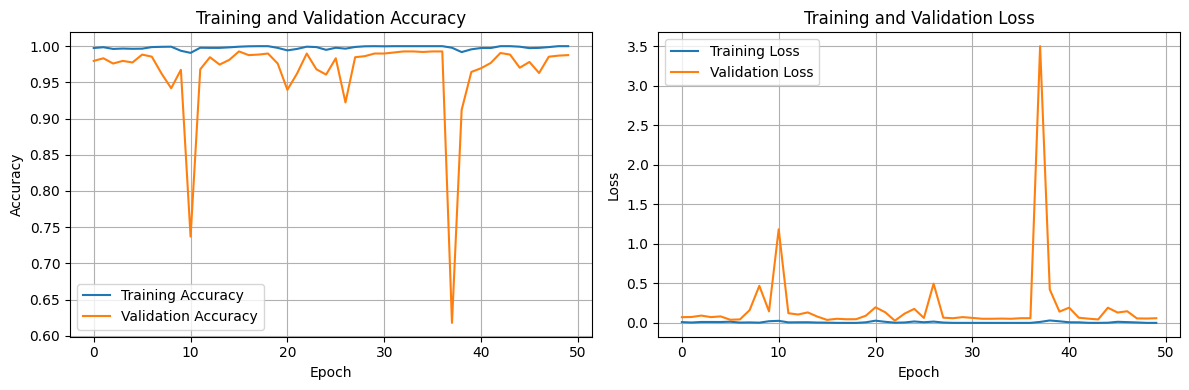

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
classification_model.save('best_hybrid_classification_model3.keras')

# Testing Hybrid model on Test Data

In [ ]:
test_loss, test_accuracy = classification_model.evaluate(test_ds)
print(f" Test Accuracy: {test_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9955 - loss: 0.0116
 Test Accuracy: 0.9964


In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = classification_model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

y_true = tf.convert_to_tensor(y_true)
y_pred = tf.convert_to_tensor(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [ ]:
from sklearn.metrics import classification_report

class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

      glioma     1.0000    1.0000    1.0000        72
  meningioma     0.9878    1.0000    0.9939        81
    no_tumor     1.0000    0.9722    0.9859        36
   pituitary     1.0000    1.0000    1.0000        89

    accuracy                         0.9964       278
   macro avg     0.9970    0.9931    0.9949       278
weighted avg     0.9964    0.9964    0.9964       278



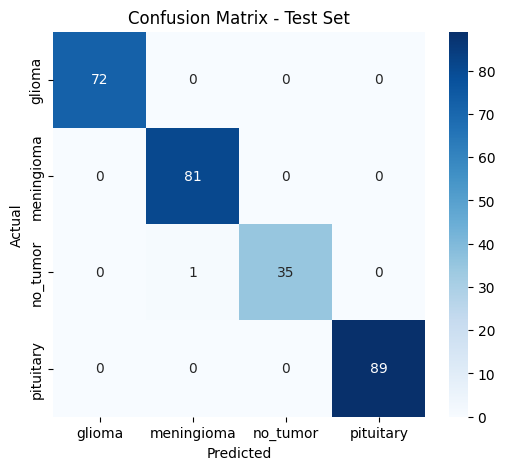

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


AUC Score (One-vs-Rest): 0.9999
AUC Score (Macro Average): 0.9999
AUC Score (Weighted Average): 0.9999

AUC per Class:
AUC for class 'glioma': 1.0000
AUC for class 'meningioma': 0.9999
AUC for class 'no_tumor': 0.9999
AUC for class 'pituitary': 1.0000


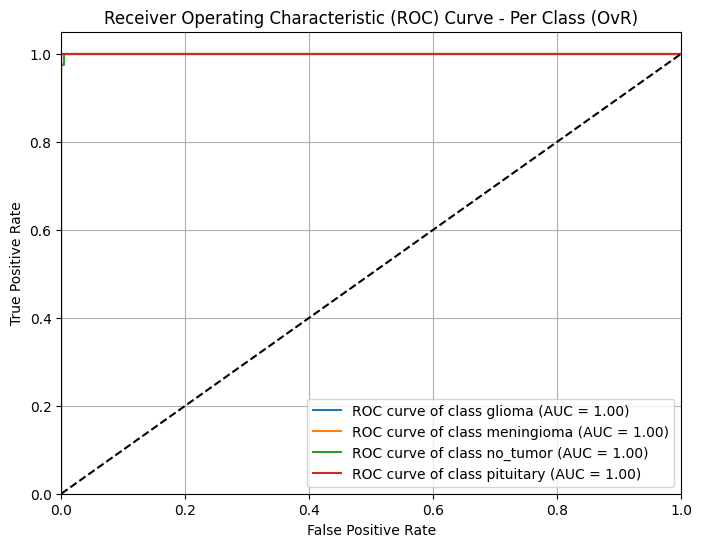

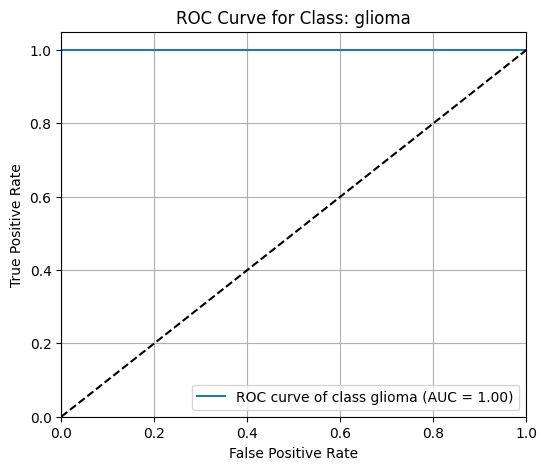

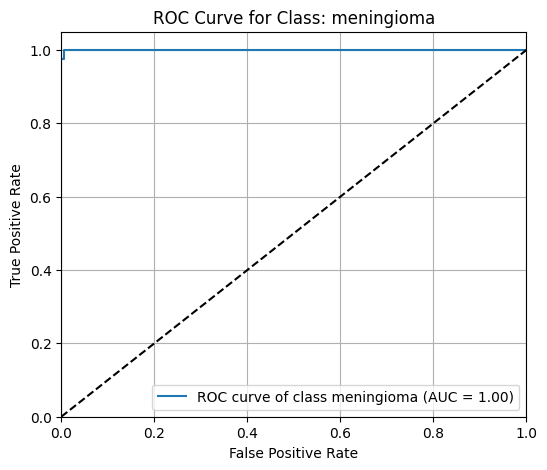

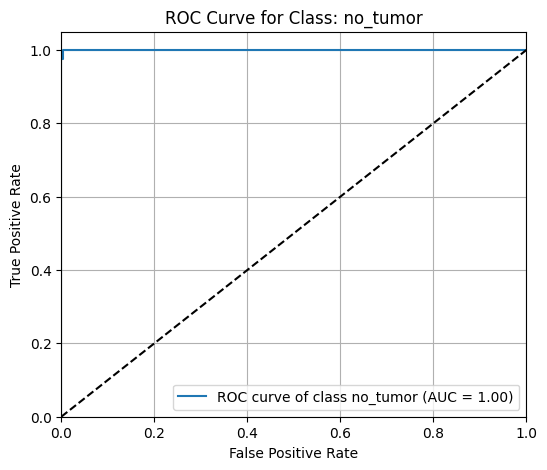

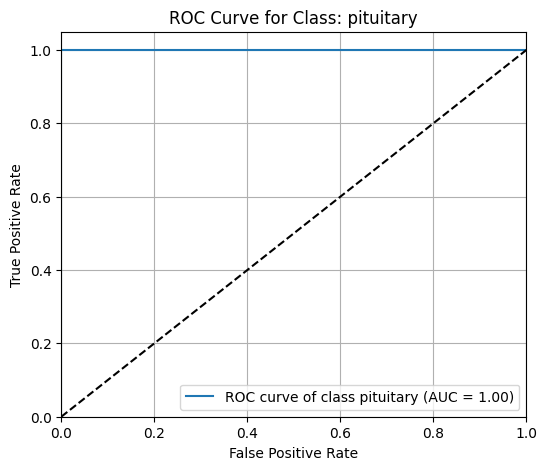

In [ ]:

from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



y_true_auc = []
y_prob = []


for images, labels in test_ds:

    probs = classification_model.predict(images, verbose=0)

    y_true_auc.extend(tf.argmax(labels, axis=1).numpy())

    y_prob.extend(probs)

y_true_auc = np.array(y_true_auc)
y_prob = np.array(y_prob)


auc_score_ovr = roc_auc_score(y_true_auc, y_prob, multi_class='ovr')


auc_score_macro = roc_auc_score(y_true_auc, y_prob, multi_class='ovr', average='macro')

auc_score_weighted = roc_auc_score(y_true_auc, y_prob, multi_class='ovr', average='weighted')


print(f"\nAUC Score (One-vs-Rest): {auc_score_ovr:.4f}")
print(f"AUC Score (Macro Average): {auc_score_macro:.4f}")
print(f"AUC Score (Weighted Average): {auc_score_weighted:.4f}")


print("\nAUC per Class:")
for i, class_name in enumerate(class_names):

    y_true_class = (y_true_auc == i).astype(int)

    y_prob_class = y_prob[:, i]

    auc_class = roc_auc_score(y_true_class, y_prob_class)
    print(f"AUC for class '{class_name}': {auc_class:.4f}")



fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(class_names)

for i in range(n_classes):

    y_true_bin = (y_true_auc == i).astype(int)

    fpr[i], tpr[i], _ = roc_curve(y_true_bin, y_prob[:, i])

    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Per Class (OvR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


for i in range(n_classes):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class: {class_names[i]}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


#GradCAM Implementation

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


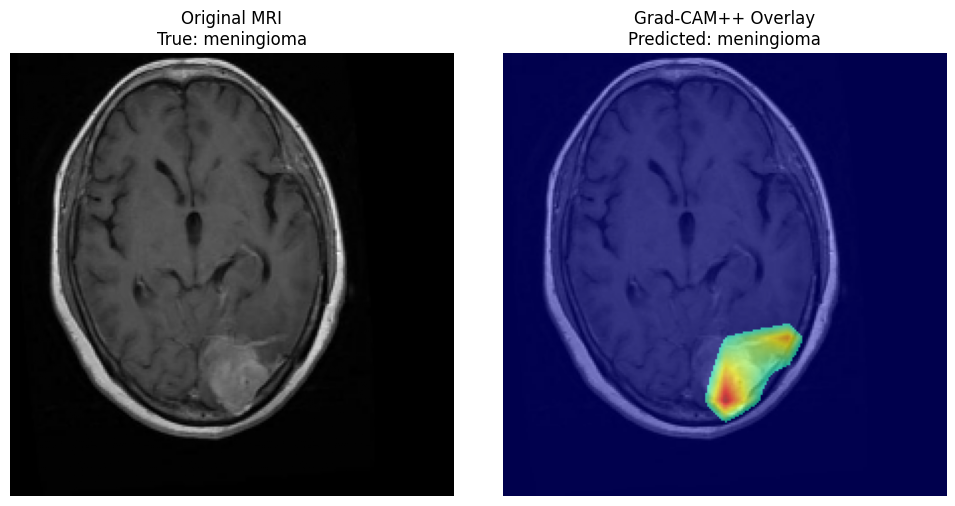

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from transformers import TFViTModel
import keras


@keras.saving.register_keras_serializable()
class ViTBranch(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

    def call(self, inputs, training=False):
        return self.vit({'pixel_values': inputs}, training=training).last_hidden_state[:, 0, :]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 768)


@keras.saving.register_keras_serializable()
class TransposeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.transpose(inputs, perm=[0, 3, 1, 2])


model = tf.keras.models.load_model('best_hybrid_classification_model3.keras',
                                   custom_objects={'TransposeLayer': TransposeLayer, 'ViTBranch': ViTBranch})


def generate_gradcam(model, img, class_index, target_layer='conv5_block3_out'):
    """Generates Grad-CAM++ visualization for classification without segmentation."""
    img_resized = cv2.resize(img, (224, 224))
    x = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(img_resized.copy(), axis=0))


    classification_output_layer = model.get_layer('classification_output')
    grad_model = tf.keras.models.Model([model.input],
                                       [model.get_layer(target_layer).output, classification_output_layer.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-8)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224), method='bilinear')
    heatmap = tf.squeeze(heatmap).numpy()


    heatmap = np.power(heatmap, 2.5)
    heatmap[heatmap < 0.4] = 0


    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)


    gray_img = cv2.cvtColor(img_resized.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(gray_img, 0.7, heatmap_color, 0.6, 0)

    return overlay, img_resized


def plot_top1_correct_gradcam(model, test_ds, class_names):
    """Plots Grad-CAM++ for top-1 correct prediction (classification only)."""
    correct_predictions = []
    count = 0

    for images, labels in test_ds:
        for i in range(len(images)):
            img = images[i].numpy()
            label = tf.argmax(labels[i]).numpy()

            preds = model.predict(np.expand_dims(img, axis=0))
            pred_class = np.argmax(preds[0])

            if pred_class == label:
                correct_predictions.append((img, label, pred_class))
                count += 1
                if count == 1:
                    break
        if count == 1:
            break

    for img, label, pred_class in correct_predictions:
        overlay, base_img = generate_gradcam(model, img, pred_class)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY), cmap='gray')
        plt.title(f"Original MRI\nTrue: {class_names[label]}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"Grad-CAM++ Overlay\nPredicted: {class_names[pred_class]}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()



plot_top1_correct_gradcam(model, test_ds, class_names)
